# Script to predict the MW - M31 orbit 

### Todo:

*** Make the script flexible so it can be used with any combination of galaxies.

## Definitions:

In [1]:
# Which galaxies to include in the integration
galaxies = ['M31', 'MW', 'LMC', 'M33']
#galaxies = ['M31', 'MW', 'M33']
#galaxies = ['M31', 'MW', 'LMC']
#galaxies = ['M31', 'MW']

# How many MC samples
N_s = 50

# What variables to include the errors of

variant = 'vary-all'
#variant = 'vary-only-LMC'
#variant = 'vary-all-little'
#variant = 'vary-constant-masses'
#variant = 'low-vt'
#variant = 'low-vt-high-mass'

#variant = 'vary-only-mass'

# we run with either clip_sigma = 1.5 or clip_sigma > 20 (the latter will have no effect)
clip_sigma = 1000

dynamical_friction = 'hierarchical' # host to satellite (standard)
dynamical_friction = 'proportional' # host to satellite, momentum conserving.
#dynamical_friction = 'mutual' # mutual
#dynamical_friction = 'none' # no DF

#variant = 'constant_masses'
#variant = 'high_vt'

## Define the default values and define the variants

In [2]:
# MW
m_MW_mean = 100          # exctracted from [Sawala, Teeraiho 2019]
m_MW_sigma = 20

c_MW = 8

# M31
m_M31_mean = 150          # exctracted from [Sawala, Teeriaho 2023]
m_M31_sigma = 50

dmod_M31_mean = 24.45    # extracted from [De Grisj, July 2014]
dmod_M31_sigma = 0.10

pm_ra_cosdec_M31_mean = 48.9  # Salomon
pm_ra_cosdec_M31_sigma = 10.5 

pm_dec_M31_mean = -36.9
pm_dec_M31_sigma = 8.1

vr_M31_mean = -301 #exctracted from [wiki]
vr_M31_sigma = 5

c_M31 = 8


# M33
m_M33_mean= 40 
m_M33_sigma= 15

dmod_M33_mean = 24.67 #pm 0.07
dmod_M33_sigma = 0.07

pm_ra_cosdec_M33_mean = 31 #exctracted from [Van der Marel, 2019]
pm_ra_cosdec_M33_sigma = 19 # 19 

pm_dec_M33_mean = -29
pm_dec_M33_sigma = 16 # 16

vr_M33_mean = -179.2 # exctracted from Simbad Univ Strasbourg
vr_M33_sigma = 3

c_M33 = 8


# LMC
m_LMC_mean = 20.  # exctracted from [Erkal, Denis 2019]
m_LMC_sigma = 10.

dmod_LMC_mean = 18.477
dmod_LMC_sigma = 0.026

pm_ra_cosdec_LMC_mean = 1.910 * 1000     #exctracted from [Kallivayalil, 2013]
pm_ra_cosdec_LMC_sigma = 0.020 * 1000 

pm_dec_LMC_mean = 0.229 * 1000 
pm_dec_LMC_sigma = 0.047 * 1000

vr_LMC_mean = 262.2
vr_LMC_sigma = 3

c_LMC = 8

# MW is always 0
# M31 is always 1

if 'LMC' in galaxies:
    idx_LMC = 2
if 'M33' in galaxies: # but not the LMC
    idx_M33 = 2
if 'LMC' in galaxies and 'M33' in galaxies:
    idx_LMC = 2; idx_M33 = 3


match variant:
    case 'vary-all':
        print ('all vary (default)')

    case 'vary-all-little':
        factor = 0.1

        m_MW_sigma = m_MW_sigma * factor
        m_M31_sigma = m_M31_sigma * factor
        m_LMC_sigma = m_LMC_sigma * factor
        m_M33_sigma = m_M33_sigma * factor
        
        dmod_M31_sigma = dmod_M31_sigma * factor
        dmod_LMC_sigma = dmod_LMC_sigma * factor
        dmod_M33_sigma = dmod_M33_sigma * factor

        pm_ra_cosdec_M31_sigma = pm_ra_cosdec_M31_sigma * factor
        pm_ra_cosdec_LMC_sigma = pm_ra_cosdec_LMC_sigma * factor
        pm_ra_cosdec_M33_sigma = pm_ra_cosdec_M33_sigma * factor

        vr_M31_sigma = vr_M31_sigma * factor
        vr_LMC_sigma = vr_LMC_sigma * factor
        vr_M33_sigma = vr_M33_sigma * factor

        pm_dec_M31_sigma = pm_dec_M31_sigma * factor
        pm_dec_M33_sigma = pm_dec_M33_sigma * factor
        pm_dec_LMC_sigma = pm_dec_LMC_sigma * factor
        
        print ('all vary only very little')

    case 'vary-constant-masses':
        m_MW_sigma = 0
        m_M31_sigma = 0
        m_LMC_sigma = 0
        m_M33_sigma = 0
        print ('set mass variation to zero')

    case 'vary-only-mass':
        dmod_M31_sigma = 0
        dmod_LMC_sigma = 0
        dmod_M33_sigma = 0

        pm_ra_cosdec_M31_sigma = 0
        pm_ra_cosdec_LMC_sigma = 0
        pm_ra_cosdec_M33_sigma = 0

        vr_M31_sigma = 0
        vr_LMC_sigma = 0
        vr_M33_sigma = 0

        pm_dec_M31_sigma = 0
        pm_dec_M33_sigma = 0
        pm_dec_LMC_sigma = 0

    case 'vary-only-LMC':
        m_MW_sigma = 0
        m_M31_sigma = 0
        m_M33_sigma = 0
          
        dmod_M31_sigma = 0
        dmod_M33_sigma = 0

        pm_ra_cosdec_M31_sigma = 0
        pm_ra_cosdec_M33_sigma = 0

        vr_M31_sigma = 0
        vr_M33_sigma = 0

        pm_dec_M31_sigma = 0
        pm_dec_M33_sigma = 0

    case 'low-vt':                     # this gives an average vt of around 39.6 km/s, and both values are within 1 sigma
        pm_ra_cosdec_M31_sigma = 10
        pm_ra_cosdec_M31_mean = 38.9
        pm_dec_M31_sigma = 10
        pm_dec_M31_mean = -32.2
        
        print ('low vt')

    case 'low-vt-high-mass':                     # this gives an average vt of around 39.6 km/s, and both values are within 1 sigma
        pm_ra_cosdec_M31_sigma = 10
        pm_ra_cosdec_M31_mean = 38.9
        pm_dec_M31_sigma = 10
        pm_dec_M31_mean = -32.2
        
        m_MW_mean = 150         
        m_MW_sigma = 20
        m_M31_mean = 250          
        m_M31_sigma = 50
        
        print ('low vt and high mass')

    case _:
        print("undefined variant, default used")

all vary (default)


In [3]:
suffix = ''

suffix+='_gx'
N = len(galaxies)
for i in range (N):
    suffix +='-'+galaxies[i]

suffix +='_Ns-'+str(N_s)

suffix +='_'+variant

suffix +='_DF-'+dynamical_friction

if clip_sigma < 20:
    suffix +='_clip-'+str(clip_sigma)

print ("suffix:", suffix)

suffix: _gx-M31-MW-LMC-M33_Ns-50_vary-all_DF-proportional


## Imports

In [4]:
#Math librairies
import numpy as np
from tqdm import tqdm
from scipy.interpolate import CubicSpline
import math

from scipy.stats import truncnorm
from scipy.signal import argrelextrema


#Astro libraries
import astropy.units as u
import astropy.constants as c
from astropy.coordinates import Galactocentric

from astropy import coordinates as coord

from astropy.coordinates import SkyCoord
from astropy.coordinates import Distance

from galpy import potential

from colossus.cosmology import cosmology
from colossus.halo import profile_nfw
cosmo = cosmology.setCosmology('planck18') 

#Plotting libraries
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from scipy.ndimage.filters import gaussian_filter
import matplotlib.cm as cm
from matplotlib.colors import LogNorm

from PIL import Image
from PIL import ImageChops

/tmp/ipykernel_68455/2784809515.py:30: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter



#### We use the following units:

    * velocity: km/s
    * distance: kpc
    * mass: 10**10 Msun
    * time: Gyr

# Simulation parameters

In [5]:
#Time parameters
t         = 0      # current time of the simulation

tEnd      = 10  # time at which simulation ends
dt        = .001    # timestep

#T=np.linspace(t, tEnd, int(tEnd / dt) +1) #list contaning all time values

#Hernquist softening length
softening = 20

G = 43007 # Gravitational constant in appropriate units

## functions used in this notebook

In [6]:
def getAcc(pos, mass, G, softening ):
    """
    Calculate the acceleration on each particle due to Newton's Law 
    pos  is an N x 3 matrix of positions
    mass is an N x 1 vector of masses
    a is N x 3 matrix of accelerations
    """
    # positions r = [x,y,z] for all particles
    x = pos[:,0:1]
    y = pos[:,1:2]
    z = pos[:,2:3]

#    print ("x:", x)
#    print ("y:", y)

    # matrix that stores all pairwise particle separations: r_j - r_i
    dx = x.T - x
    dy = y.T - y
    dz = z.T - z

#    print ("dx:", dx)
    
    # matrix that stores 1/r^3 for all particle pairwise particle separations 
    inv_r3 = (dx**2 + dy**2 + dz**2 + softening**2)
    inv_r3[inv_r3>0] = inv_r3[inv_r3>0]**(-1.5)

    ax = G * (dx * inv_r3) @ mass
    ay = G * (dy * inv_r3) @ mass
    az = G * (dz * inv_r3) @ mass

#    print ("ax", ax)

    # pack together the acceleration components
    a = np.hstack((ax,ay,az))

#    print ("a hstack:", a)

    a = np.vstack((ax,ay,az)).T

#    print ("a vstack:", a)

    return a

## https://academic.oup.com/mnras/article/483/2/2185/5181341

## https://academic.oup.com/mnras/article/461/2/2212/2608460

In [7]:
def density_NFW( r, M200, c200, Rs):
	"""Computes the NFW density at distance r from the halo centre."""
	return M200 / (4.*np.pi * g_NFW(c200) * r * (r+Rs)*(r+Rs) )

In [8]:
def g_NFW(x):
	""" Returns ln(1+x) - x/(1+x)."""
	return np.log(1+x) - x/(1.+x)

In [9]:
def getDynamicalFriction_proportional(pos, mass, vel, concentrations, r_s, r_200, vmax, G):

    """
    Calculate the Dynamical Friction of each pair of galaxies.
    This (mutual) assumes that both the satellites and the host are extended
    and that only the host exerts dynamical friction on the satellite, but in a momentum-conserving manner
    """
    
    N = len(mass)
    
    # i will be the index of the galaxy on which the dynamical friction acts. ("satellite")
    # j will be the index of the galaxy whose halo is causing dynamical friction. ("host")

    # friction is an array that contains the dynamical friction forces in x, y, z,
    # for all N galaxies by all N-1 other galaxies, summed up
    friction = np.zeros((N,3), dtype = 'float')

    for i in range(N):
        for j in range(N): 
            if (i != j) and mass[i] > 0 and mass[j] > 0 and mass[j] > mass[i]:
    
                dr = pos[i] - pos[j]
                r = max(10, np.linalg.norm(dr)) # below 10 kpc, a merger should have occured
                
                if r < (r_200[j]): # only apply when the satellite is within r200 of the host

                    # relative velocity
                    dv = (vel[i,:] - vel[j,:]) 
                    v = np.linalg.norm(dv) 
                    
                    # density of the host
                    rho = density_NFW(r, mass[j], concentrations[j], r_s[j])

                    # velocity dispersion of the host
                    x = r / r_s[j]
                    sigma_v = vmax[j] * 1.4393 * x**0.354 / (1.+1.1756 * x**0.725)		# 1D halo dispersion from Zentner & Bullock (2003)

                    y = v / (np.sqrt(2.) * sigma_v)    
                    integral = math.erf( y ) - 2.*y / np.sqrt( np.pi ) * np.exp( -y*y )  # the integral of v^2 for a Maxwellian velocity distribution

                    # scale radius of the satellite
                    if r_s[i] > 8.0 :                    # this comes from https://academic.oup.com/mnras/article/461/2/2212/2608460#equ7
                        epsilon = 2.2 * r_s[i] - 14
                    else:
                        epsilon = 0.45 * r_s[i]

                    gamma = r / epsilon

                    fricmag = 4.0 * np.pi * G**2 * math.log(gamma) * mass[i] * rho * integral / (max(v,5))**3

                    friction[i] -= dv * fricmag * mass[j] / (mass[i] + mass[j])
                    friction[j] += dv * fricmag * mass[i] / (mass[i] + mass[j])

    return friction


def getDynamicalFriction_hierarchical(pos, mass, vel, concentrations, r_s, r_200, vmax, G):

    """
    Calculate the Dynamical Friction of each pair of galaxies.
    This (hierarchical) assumes that both the satellites and the host are extended
    but that only the host (more massive) exerts Dynamical Friction on the satellite.
    """
    
    N = len(mass)
    
    # i will be the index of the galaxy on which the dynamical friction acts. ("satellite")
    # j will be the index of the galaxy whose halo is causing dynamical friction. ("host")

    # friction is an array that contains the dynamical friction forces in x, y, z,
    # for all N galaxies by all N-1 other galaxies, summed up
    friction = np.zeros((N,3), dtype = 'float')

    for i in range(N):
        for j in range(N): 
            if (i != j) and mass[i] > 0 and mass[j] > 0 and mass[j] > mass[i]:
    
                dr = pos[i] - pos[j]
                r = max(10, np.linalg.norm(dr)) # below 10 kpc, a merger should have occured
                
                if r < (r_200[j]): # only apply when the satellite is within r200 of the host

                    # relative velocity
                    dv = (vel[i,:] - vel[j,:]) 
                    v = np.linalg.norm(dv) 
                    
                    # density of the host
                    rho = density_NFW(r, mass[j], concentrations[j], r_s[j])

                    # velocity dispersion of the host
                    x = r / r_s[j]
                    sigma_v = vmax[j] * 1.4393 * x**0.354 / (1.+1.1756 * x**0.725)		# 1D halo dispersion from Zentner & Bullock (2003)

                    y = v / (np.sqrt(2.) * sigma_v)    
                    integral = math.erf( y ) - 2.*y / np.sqrt( np.pi ) * np.exp( -y*y )  # the integral of v^2 for a Maxwellian velocity distribution

                    # scale radius of the satellite
                    if r_s[i] > 8.0 :                    # this comes from https://academic.oup.com/mnras/article/461/2/2212/2608460#equ7
                        epsilon = 2.2 * r_s[i] - 14
                    else:
                        epsilon = 0.45 * r_s[i]

                    gamma = r / epsilon

                    fricmag = 4.0 * np.pi * G**2 * math.log(gamma) * mass[i] * rho * integral / (max(v,5))**3

                    friction[i] -= dv * fricmag 

    return friction


def getDynamicalFriction_mutual(pos, mass, vel, concentrations, r_s, r_200, vmax, G):

    """
    Calculate the Dynamical Friction of each pair of galaxies.
    This (mutual) assumes that both the satellites and the host are extended
    and both exert friction on each other.
    """
    
    N = len(mass)
    
    # i will be the index of the galaxy on which the dynamical friction acts. ("satellite")
    # j will be the index of the galaxy whose halo is causing dynamical friction. ("host")

    # friction is an array that contains the dynamical friction forces in x, y, z,
    # for all N galaxies by all N-1 other galaxies, summed up
    friction = np.zeros((N,3), dtype = 'float')

    for i in range(N):
        for j in range(N): 
            if (i != j) and mass[i] > 0 and mass[j] > 0:
    
                dr = pos[i] - pos[j]
                r = max(10, np.linalg.norm(dr)) # below 10 kpc, a merger should have occured
                
                if r < (r_200[j]): # only apply when the satellite is within r200 of the host

                    # relative velocity
                    dv = (vel[i,:] - vel[j,:]) 
                    v = np.linalg.norm(dv) 
                    
                    # density of the host
                    rho = density_NFW(r, mass[j], concentrations[j], r_s[j])

                    # velocity dispersion of the host
                    x = r / r_s[j]
                    sigma_v = vmax[j] * 1.4393 * x**0.354 / (1.+1.1756 * x**0.725)		# 1D halo dispersion from Zentner & Bullock (2003)

                    y = v / (np.sqrt(2.) * sigma_v)    
                    integral = math.erf( y ) - 2.*y / np.sqrt( np.pi ) * np.exp( -y*y )  # the integral of v^2 for a Maxwellian velocity distribution

                    # scale radius of the satellite
                    if r_s[i] > 8.0 :                    # this comes from https://academic.oup.com/mnras/article/461/2/2212/2608460#equ7
                        epsilon = 2.2 * r_s[i] - 14
                    else:
                        epsilon = 0.45 * r_s[i]

                    gamma = r / epsilon

                    fricmag = 4.0 * np.pi * G**2 * math.log(gamma) * mass[i] * rho * integral / (max(v,5))**3

                    friction[i] -= dv * fricmag

    return friction



### Get Galaxy's coordinates and transform into galactocentric frame.

In [10]:
def get_galaxy_coordinates(Galaxy, d_mod, pm_ra_cosdec, pm_dec, vr, mass):
    
    coo=(SkyCoord.from_name(Galaxy))
    sky=SkyCoord(ra=coo.ra,dec=coo.dec,frame='icrs',distance=Distance(distmod=d_mod*u.mag),
                 pm_ra_cosdec=pm_ra_cosdec*u.uas/u.yr, pm_dec=pm_dec*u.uas/u.yr,radial_velocity=vr*u.km/u.s)

    gal=sky.transform_to(Galactocentric()) #convert ICRS coordinates to Galactocentric coordinates
    pos = [gal.x.value,gal.y.value,gal.z.value] #positions array for the concerned galaxy
    vel = [gal.v_x.value, gal.v_y.value, gal.v_z.value] #velocities array

    return pos, vel, mass #returns coordinates

## Create the initial conditions

### We reset the random seed to the index of the sample, + 1e8 for M31, + 2e8 for the LMC, + 3e8 for M33
### in order to get reproducible values even when the number of galaxies and the sample size change.


In [11]:
ICs = {'masses': [], 'positions': [], 'velocities': [], 'concentrations': []}

print ("N_s", N_s)
print ("N", N)

# create the samples:

k = 0  ; np.random.seed(k) ; m_MW = truncnorm( -clip_sigma, clip_sigma, loc=m_MW_mean, scale=m_MW_sigma).rvs(N_s)

k += 1 ; np.random.seed(k) ; dmod_M31 = truncnorm( -clip_sigma, clip_sigma, loc=dmod_M31_mean, scale=dmod_M31_sigma).rvs(N_s)
k += 1 ; np.random.seed(k) ; pm_ra_cosdec_M31 = truncnorm( -clip_sigma, clip_sigma, loc=pm_ra_cosdec_M31_mean, scale=pm_ra_cosdec_M31_sigma).rvs(N_s)
k += 1 ; np.random.seed(k) ; pm_dec_M31 = truncnorm( -clip_sigma, clip_sigma, loc=pm_dec_M31_mean, scale=pm_dec_M31_sigma).rvs(N_s)
k += 1 ; np.random.seed(k) ; vr_M31 = truncnorm( -clip_sigma, clip_sigma, loc=vr_M31_mean, scale=vr_M31_sigma).rvs(N_s)
k += 1 ; np.random.seed(k) ; m_M31 = truncnorm( -clip_sigma, clip_sigma, loc=m_M31_mean, scale=m_M31_sigma).rvs(N_s)

k += 1 ; np.random.seed(k) ; dmod_LMC = truncnorm( -clip_sigma, clip_sigma, loc=dmod_LMC_mean, scale=dmod_LMC_sigma).rvs(N_s)
k += 1 ; np.random.seed(k) ; pm_ra_cosdec_LMC = truncnorm( -clip_sigma, clip_sigma, loc=pm_ra_cosdec_LMC_mean, scale=pm_ra_cosdec_LMC_sigma).rvs(N_s)
k += 1 ; np.random.seed(k) ; pm_dec_LMC = truncnorm( -clip_sigma, clip_sigma, loc=pm_dec_LMC_mean, scale=pm_dec_LMC_sigma).rvs(N_s)
k += 1 ; np.random.seed(k) ; vr_LMC = truncnorm( -clip_sigma, clip_sigma, loc=vr_LMC_mean, scale=vr_LMC_sigma).rvs(N_s)
k += 1 ; np.random.seed(k) ; m_LMC = truncnorm( -clip_sigma, clip_sigma, loc=m_LMC_mean, scale=m_LMC_sigma).rvs(N_s)

k += 1 ; np.random.seed(k) ; dmod_M33 = truncnorm( -clip_sigma, clip_sigma, loc=dmod_M33_mean, scale=dmod_M33_sigma).rvs(N_s)
k += 1 ; np.random.seed(k) ; pm_ra_cosdec_M33 = truncnorm( -clip_sigma, clip_sigma, loc=pm_ra_cosdec_M33_mean, scale=pm_ra_cosdec_M33_sigma).rvs(N_s)
k += 1 ; np.random.seed(k) ; pm_dec_M33 = truncnorm( -clip_sigma, clip_sigma, loc=pm_dec_M33_mean, scale=pm_dec_M33_sigma).rvs(N_s)
k += 1 ; np.random.seed(k) ; vr_M33 = truncnorm( -clip_sigma, clip_sigma, loc=vr_M33_mean, scale=vr_M33_sigma).rvs(N_s)
k += 1 ; np.random.seed(k) ; m_M33 = truncnorm( -clip_sigma, clip_sigma, loc=m_M33_mean, scale=m_M33_sigma).rvs(N_s)


for s in range (N_s):
    
    masses = []
    positions = []
    concentrations = []
    velocities = []

    if 'MW' in galaxies:
        
        pos_MW = [0.,0.,0.]
        vel_MW = [0.,0.,0.]
        masses.append(m_MW[s]); positions.append(pos_MW); velocities.append(vel_MW); concentrations.append(c_MW)

    if 'M31' in galaxies:
        pos_M31, vel_M31, mass_M31 = get_galaxy_coordinates('M31', dmod_M31[s], pm_ra_cosdec_M31[s], pm_dec_M31[s], vr_M31[s], m_M31[s])        
#        masses.append(np.array(mass_M31)); positions.append(np.array(pos_M31)); velocities.append(np.array(vel_M31)); concentrations.append(np.array(c_M31))
        masses.append(mass_M31); positions.append(pos_M31); velocities.append(vel_M31); concentrations.append(c_M31)
                                                                                                                                            
    if 'LMC' in galaxies:

        pos_LMC, vel_LMC, mass_LMC = get_galaxy_coordinates('LMC', dmod_LMC[s], pm_ra_cosdec_LMC[s], pm_dec_LMC[s], vr_LMC[s], m_LMC[s])
#        masses.append(np.array(mass_LMC)); positions.append(np.array(pos_LMC)); velocities.append(np.array(vel_LMC)); concentrations.append(np.array(c_M31))
        masses.append(mass_LMC); positions.append(pos_LMC); velocities.append(vel_LMC); concentrations.append(c_LMC)
    
    if 'M33' in galaxies:
        
        pos_M33, vel_M33, mass_M33 = get_galaxy_coordinates('M33', dmod_M33[s], pm_ra_cosdec_M33[s], pm_dec_M33[s], vr_M33[s], m_M33[s])
#        masses.append(np.array(mass_M33)); positions.append(np.array(pos_M33)); velocities.append(np.array(vel_M33)); concentrations.append(np.array(c_M33))
        masses.append(mass_M33); positions.append(pos_M33); velocities.append(vel_M33); concentrations.append(c_M33)

#    ICs['masses'].append(np.array(masses))
#    ICs['positions'].append(np.array(positions))
#    ICs['concentrations'].append(np.array(concentrations))
#    ICs['velocities'].append(np.array(velocities))

    ICs['masses'].append(masses)
    ICs['positions'].append(positions)
    ICs['concentrations'].append(concentrations)
    ICs['velocities'].append(velocities)

print ("galaxies:", galaxies)
#print ("masses", ICs['masses'])
#print ("positions", ICs['positions'])
#print ("velocities", ICs['velocities'])



N_s 50
N 4
galaxies: ['M31', 'MW', 'LMC', 'M33']


# Orbit integration

In [12]:
# number of timesteps
Nt = int(np.ceil(tEnd/dt))

print ("Nt:", Nt)

orbits = []
vels = []
accelerations = []
frictions = []
existence = []

for s in tqdm(range (N_s)):

    positions = np.array(ICs['positions'][s])
    masses = np.array(ICs['masses'][s])
    velocities = np.array(ICs['velocities'][s])
    concentrations = np.array(ICs['concentrations'][s])

#    positions = ICs['positions'][s]
#    masses = ICs['masses'][s]
#    velocities = ICs['velocities'][s]
#    concentrations = ICs['concentrations'][s]

    
    if s == 0:
        print ("masses:", masses)
        print ("velocities:", velocities)

    r_s = []
    vmax = []

    # calculate properties of the NFW profiles of the halos:
    for i in range(N):
        profile = profile_nfw.NFWProfile(M = masses[i] * 1.e10 * cosmo.h, c = concentrations[i], z = 0.0, mdef = '200c') # this assumes mass in solar masses

        this_r_s = profile.par['rs']
        this_vmax = profile.Vmax()[0]        
        r_s.append(this_r_s)
        vmax.append(this_vmax)

    r_s = np.array(np.ravel(r_s))
    vmax = np.array(np.ravel(vmax))
    r_200 = r_s * concentrations
    
    # calculate initial gravitational accelerations
    
    acc = getAcc( positions, masses, G, softening )


    match dynamical_friction:
        case 'none':
            fric = np.zeros((N,3), dtype = 'float')
        case 'mutual':
            fric = getDynamicalFriction_mutual(positions, masses, velocities, concentrations, r_s, r_200, vmax, G)
        case 'hierarchical':
            fric = getDynamicalFriction_hierarchical(positions, masses, velocities, concentrations, r_s, r_200, vmax, G)
        case 'proportional':
            fric = getDynamicalFriction_proportional(positions, masses, velocities, concentrations, r_s, r_200, vmax, G)

    
    if s == 0:
        print ("first realisation, initial acc:\n", acc)
        print ("initial fric:\n", fric)
        print ("initial velocities", velocities)
        print ("initial positions:", positions)
        print ("masses:", masses)
        print ("r_s:", r_s)
        print ("r200:", r_200)

        print ("cm frame:", velocities - np.mean(np.array([masses]).T * velocities,0) / np.mean([masses]))

    # save particle orbits for plotting trails
    
    pos_save = np.zeros((N,3,Nt+1))
    pos_save[:,:,0] = positions
    
    vel_save = np.zeros((N,3,Nt+1))
    vel_save[:,:,0] = velocities     

    acc_save = np.zeros((N,Nt+1))
    fric_save = np.zeros((N,Nt+1))

    exists_save = np.ones((N,Nt+1))
    
    t_all = np.arange(Nt+1)*dt
    
    t=0
    
    # Simulation Main Loop = Leapfrog integration for N galaxies 

    # Convert to Center-of-Mass frame
#    velocities -= np.mean([masses] * velocities,0) / np.mean([masses])
    velocities -= np.mean(np.array([masses]).T * velocities,0) / np.mean([masses])

    exists = list(range(N)) # all galaxies exist
    
    for i in range(Nt):
        # (1/2) kick
        velocities += (acc + fric) * dt /2.0
        # drift
        positions += velocities * dt
    
        # update accelerations
        acc = getAcc( positions, masses, G, softening )
    
        # calculate dynamical friction
        
        match dynamical_friction:
            case 'none':
                fric = np.zeros((N,3), dtype = 'float')
            case 'mutual':
                fric = getDynamicalFriction_mutual(positions, masses, velocities, concentrations, r_s, r_200, vmax, G)
            case 'hierarchical':
                fric = getDynamicalFriction_hierarchical(positions, masses, velocities, concentrations, r_s, r_200, vmax, G)
            case 'proportional':
                fric = getDynamicalFriction_proportional(positions, masses, velocities, concentrations, r_s, r_200, vmax, G)

    
        # (1/2) kick
        velocities += (acc + fric) * dt/2.0
    
        # update time
        t += dt

        # check for mergers
        
        for l in exists:
            for m in exists:
                if l > m :
                    if np.linalg.norm(positions[l,:]-positions[m,:], axis=0) < 10 :
    
                        if masses[l] > masses[m] :
                            remove = m
                            keep = l
                        else:
                            remove = l
                            keep = m

                        exists.remove(remove)

             #           print('Galaxy '+str(remove)+' has merged with galaxy '+ str(keep) +' at',t,'Gyr')
                        positions[keep] = (masses[keep] * positions[keep] + masses[remove] * positions[remove] ) / (masses[keep] + masses[remove] )
                        velocities[keep] = (masses[keep] * velocities[keep] + masses[remove] * velocities[remove] ) / (masses[keep] + masses[remove] )

                        masses[keep]=masses[keep]+masses[remove]
                        masses[remove]=0
                        exists_save[remove,i:-1] = 0
                        pos_save[remove,:,i:-1] = np.ones((3, Nt-i))*-1e10 # this means the rest of the orbit won't be plotted
                        vel_save[remove,:,i:-1] = np.ones((3, Nt-i))*-1e10 

        # save positions for plotting trail
        pos_save[exists,:,i+1] = positions[exists,:] 
        vel_save[exists,:,i+1] = velocities[exists,:]
        acc_save[:,i+1] = np.linalg.norm(acc, axis=1)
        fric_save[:,i+1] = np.linalg.norm(fric, axis=1)

    orbits.append(pos_save)
    vels.append(vel_save)
    accelerations.append(acc_save)
    frictions.append(fric_save)
    existence.append(exists_save)

#    print ("orbits[0]", orbits[0])

orbits = np.stack(orbits)
vels = np.stack(vels)
accelerations = np.stack(accelerations)
frictions = np.stack(frictions)
existence = np.stack(existence)

print ("all done")

Nt: 10000


  0%|                                                    | 0/50 [00:00<?, ?it/s]

masses: [102.45328455 111.72604795  27.43203122  55.47063762]
velocities: [[   0.            0.            0.        ]
 [  36.32552635 -116.18096616  -12.27074595]
 [ -51.75235603 -221.21730912  229.43414561]
 [  96.78614254   73.7265194    52.64684967]]
first realisation, initial acc:
 [[  -9.90344667 -309.69058738 -213.86848339]
 [ -23.89610482  -29.72027122  -31.87706579]
 [   9.19071775 1196.53486944  777.31109399]
 [  61.87666274   40.12869726   74.8108395 ]]
initial fric:
 [[  -8.16102326  -34.88458775   36.18033154]
 [   0.            0.            0.        ]
 [  30.47982964  130.28712918 -135.12647942]
 [   0.            0.            0.        ]]
initial velocities [[   0.            0.            0.        ]
 [  36.32552635 -116.18096616  -12.27074595]
 [ -51.75235603 -221.21730912  229.43414561]
 [  96.78614254   73.7265194    52.64684967]]
initial positions: [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-3.78926762e+02  6.11698863e+02 -2.81708846e+02]
 [-5.14744144e

  2%|▉                                           | 1/50 [00:00<00:39,  1.26it/s]

/home/till/.local/lib/python3.10/site-packages/colossus/halo/mass_so.py:230: RuntimeWarning: invalid value encountered in scalar power
  R = (M * 3.0 / 4.0 / np.pi / rho)**(1.0 / 3.0)



100%|███████████████████████████████████████████| 50/50 [00:40<00:00,  1.24it/s]

all done


## Save to file

In [13]:
np.savez('orbit_file'+suffix, variant=variant, galaxies = galaxies, ICs = ICs, orbits=orbits, vels = vels, N = N, N_s = N_s, frictions=frictions, accelerations=accelerations, existence=existence)

In [14]:

with np.load('orbit_file'+suffix+'.npz') as data:
    variant= data['variant']
    galaxies = data['galaxies']
    orbits = data['orbits']
    vels = data['vels']
    N = data['N']
    N_s = data['N_s']
    frictions =  data['frictions']
    accelerations =  data['accelerations']
    existence =  data['existence']

print ("vels[0,:,:,0]", vels[0,:,:,0]) 
print ("suffix:", suffix)

vels[0,:,:,0] [[   0.            0.            0.        ]
 [  36.32552635 -116.18096616  -12.27074595]
 [ -51.75235603 -221.21730912  229.43414561]
 [  96.78614254   73.7265194    52.64684967]]
suffix: _gx-M31-MW-LMC-M33_Ns-50_vary-all_DF-proportional


### Calculate the distances and adjust them when the halo no longer exists.
### Also adjust the orbits when the halo no longer exists.

In [15]:
from scipy.signal import argrelextrema

# calculate the important distances

d_M31_MW = np.linalg.norm(orbits[:,1,:,:] - orbits[:,0,:,:],axis=1)

if 'LMC' in galaxies:
    d_LMC_MW = np.linalg.norm(orbits[:,idx_LMC,:,:] - orbits[:,0,:,:],axis=1)
if 'M33' in galaxies:
    d_M33_MW = np.linalg.norm(orbits[:,idx_M33,:,:] - orbits[:,0,:,:],axis=1)
    d_M33_M31 = np.linalg.norm(orbits[:,idx_M33,:,:] - orbits[:,1,:,:],axis=1)

# Find the merger index. Also set the distances to -1 after the merger of one of the pairs:

b_M31_MW_array = np.ones(N_s) * 800.       # first minimum of the distance
dmin_M31_MW_array = np.ones(N_s) * 800.    # minimum of the distance
t_b_M31_MW_array = np.ones(N_s) * 11.      # time of first minimum of the distance
t_m_M31_MW_array = np.ones(N_s) * 11.      # time of merger [default = 11]

b_LMC_MW_array = np.ones(N_s) * 800.       # first minimum of the distance
dmin_LMC_MW_array = np.ones(N_s) * 800.    # minimum of the distance
t_b_LMC_MW_array = np.ones(N_s) * 11.      # time of first minimum of the distance
t_m_LMC_MW_array = np.ones(N_s) * 11.      # time of merger [default = 11]

b_M33_M31_array = np.ones(N_s) * 800.       # first minimum of the distance
dmin_M33_M31_array = np.ones(N_s) * 800.     # minimum of the distance
t_b_M33_M31_array = np.ones(N_s) * 11.      # time of first minimum of the distance
t_m_M33_M31_array = np.ones(N_s) * 11.      # time of merger [default = 11]


idx_merger_MW_M31 = np.ones(N_s, dtype=int) * -1
idx_merger_LMC_MW = np.ones(N_s, dtype=int) * -1
idx_merger_M33_M31 = np.ones(N_s, dtype=int) * -1


for s in range (N_s):
    
    # M31 - MW

    merged = np.where((existence[s,1,:] == 0) | (existence[s,0,:] == 0) )[0] # either the MW or the M31 no longer exist 
    d_M31_MW[s,merged] = np.ones(len(merged)) * -1. # just for the plotting

    minima = argrelextrema(d_M31_MW[s,:], np.less)[0]
    dmin_M31_MW_array[s] = np.min(d_M31_MW[s, d_M31_MW[s,:] > 0] )

    
    if len(merged) > 0: # a merger has happened.
        t_m_M31_MW_array[s] = t_all[merged[0]]

        idx_merger_MW_M31[s] = merged[0]
        
    if len(minima) > 0: # there is at least one local minimum
        b_M31_MW_array[s] = d_M31_MW[s,minima[0]]
        t_b_M31_MW_array[s] = t_all[minima[0]]
    else:               # if there is no local mininum, but a merger has happened, we use b=10 and the time of the merger
        if len(merged) > 0:
            b_M31_MW_array[s] = 10. 
            t_b_M31_MW_array[s] = t_all[merged[0]]

    if 'LMC' in galaxies and 'MW' in galaxies:

        # LMC - MW
        
        merged = np.where((existence[s,idx_LMC,:] == 0) | (existence[s,0,:] == 0) )[0] # either the LMC or the MW no longer exist 
        d_LMC_MW[s,merged] = np.ones(len(merged)) * -1.
    
        minima = argrelextrema(d_LMC_MW[s,:], np.less)[0]
    
        dmin_LMC_MW_array[s] = np.min(d_LMC_MW[s,  d_LMC_MW[s,:] > 0] )
    
        if len(merged) > 0: # a merger has happened.
            t_m_LMC_MW_array[s] = t_all[merged[0]]

            idx_merger_LMC_MW[s] = merged[0]

        
        if len(minima) > 0: # there is at least one local minimum
#            print ("minima:", minima)
            b_LMC_MW_array[s] = d_LMC_MW[s,minima[0]]
            t_b_LMC_MW_array[s] = t_all[minima[0]]
        else:               # if there is no local mininum, but a merger has happened, we use b=10 and the time of the merger
            if len(merged) > 0:
                b_LMC_MW_array[s] = 10. 
                t_b_LMC_MW_array[s] = t_all[merged[0]]


    if 'M33' in galaxies and 'M31' in galaxies:

        # M33 - M31
        
        merged = np.where((existence[s,idx_M33,:] == 0) | (existence[s,1,:] == 0) )[0] # either M31 or M33 no longer exist
        d_M33_M31[s,merged] = np.ones(len(merged)) * -1.
    
        minima = argrelextrema(d_M33_M31[s,:], np.less)[0]
        dmin_M33_M31_array[s] = np.min(d_M33_M31[s,  d_M33_M31[s,:] > 0] )
        
        if len(merged) > 0: # a merger has happened.
            t_m_M33_M31_array[s] = t_all[merged[0]]
            idx_merger_M33_M31[s] = merged[0]

            
        if len(minima) > 0: # there is at least one local minimum
            b_M33_M31_array[s] = d_M33_M31[s,minima[0]]
            t_b_M33_M31_array[s] = t_all[minima[0]]
        else:               # if there is no local mininum, but a merger has happened, we use b=10 and the time of the merger
            if len(merged) > 0:
                b_M33_M31_array[s] = 10. 
                t_b_M33_M31_array[s] = t_all[merged[0]]

#print ("b MW - M31:", b_M31_MW_array)
#print ("b LMC - MW:\n", b_LMC_MW_array)
#print ("t b LMC - MW:\n", t_b_LMC_MW_array)
#print ("t merger LMC - MW:\n", t_m_LMC_MW_array)




## Calculate v, v_r, v_t

In [16]:
masses_IC = []
vr_IC = []
vt_IC = []
r_IC = []
mass_M31 = []
mass_MW = []
mass_LMC = []
mass_M33 = []

for s in range(N_s):
    masses_IC.append(ICs['masses'][s][1]+ICs['masses'][s][0])
    v = np.linalg.norm(vels[s,1,:,0])
    r = np.linalg.norm(orbits[s,1,:,0])
    vr = np.dot(orbits[s,1,:,0],vels[s,1,:,0]) / r
    vt = np.sqrt(v**2 - vr**2)
    
    vr_IC.append(vr)
    vt_IC.append(vt)
    r_IC.append(r)

    mass_M31.append(ICs['masses'][s][1])

## Plot Distributions

#### Distribution of initial values

mas [[102.45328455149448, 111.72604794540602, 27.432031220557626, 55.47063761787031], [111.37218732146717, 206.4929802409294, -0.3846052456736331, 26.206287596489936], [105.2101262199199, 109.10710312250447, 23.415314536702592, 15.940842155369793], [102.25487703985044, 219.78942671070237, 26.707304910386313, 34.68475583225057], [96.14895384361027, 148.5473535775395, 19.962576260884646, 31.05161512520541], [107.48517619743961, 164.1933521276043, 12.439067539180778, 41.129056411423846], [96.85821278890052, 186.27182505987878, 11.514392040127246, 32.38822264831799], [124.72024563537722, 152.30917307284705, 27.08010759899334, 32.32637998055522], [135.89739193222022, 123.31874963967638, 10.423150997230291, 21.740202550116294], [94.07091073107442, 105.68375335768351, 6.489506612329809, 29.877886390614293], [116.24842615363134, 79.99486013592984, 24.827399923955547, 60.83956610708343], [101.44984531047217, 181.9272164377104, 36.78685734556675, 30.54080751936229], [103.42795871458483, 142.6174

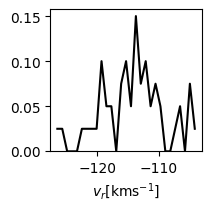

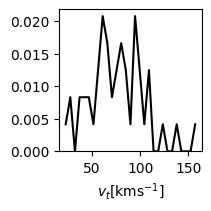

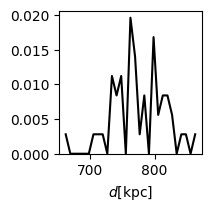

In [17]:
# vr
fig, ax = plt.subplots(1, 1, figsize=(2, 2), layout="constrained")

bin_edges = np.linspace(min(vr_IC), max(vr_IC),30)
hist, bin_edges = np.histogram(vr_IC, bins = bin_edges, density=True)
centers = (bin_edges[:-1] + bin_edges[1:]) / 2
ax.plot(centers, hist, color = 'black', label = r'$b$')

ax.set_xlabel(r'$v_r [\mathrm{kms}^{-1}]$')
ax.set_ylim(bottom=0)

plt.savefig('plots/histogram_vr_MW_M31'+suffix+'.pdf', dpi=300)

# vt
fig, ax = plt.subplots(1, 1, figsize=(2, 2), layout="constrained")

bin_edges = np.linspace(min(vt_IC), max(vt_IC),30)
hist, bin_edges = np.histogram(vt_IC, bins = bin_edges, density=True)
centers = (bin_edges[:-1] + bin_edges[1:]) / 2
ax.plot(centers, hist, color = 'black', label = r'$b$')

ax.set_xlabel(r'$v_t [\mathrm{kms}^{-1}]$')
ax.set_ylim(bottom=0)

plt.savefig('plots/histogram_vt_MW_M31'+suffix+'.pdf', dpi=300)

# d
fig, ax = plt.subplots(1, 1, figsize=(2, 2), layout="constrained")

bin_edges = np.linspace(min(r_IC), max(r_IC),30)
hist, bin_edges = np.histogram(r_IC, bins = bin_edges, density=True)
centers = (bin_edges[:-1] + bin_edges[1:]) / 2
ax.plot(centers, hist, color = 'black', label = r'$b$')

ax.set_xlabel(r'$d [\mathrm{kpc}]$')
ax.set_ylim(bottom=0)

plt.savefig('plots/histogram_vr_MW_M31'+suffix+'.pdf', dpi=300)

print ("mas", ICs['masses'][:])
mas = np.ravel(ICs['masses'])
print ("mas:", mas)

# M
#fig, ax = plt.subplots(1, 1, figsize=(2, 2), layout="constrained")

#bin_edges = np.linspace(np.min(ICs['masses'][:][:]), np.max(ICs['masses'][:][:]),200)

#hist, bin_edges = np.histogram(ICs['masses'][:,1], bins = bin_edges, density=True)
#centers = (bin_edges[:-1] + bin_edges[1:]) / 2
#ax.plot(centers, hist, color = 'blue', label = r'M31')

#ax.set_xlabel(r'$M [\mathrm{10^{10} M_\odot}]$')
#ax.set_ylim(bottom=0)

#plt.savefig('plots/histogram_vr_MW_M31'+suffix+'.pdf', dpi=300)


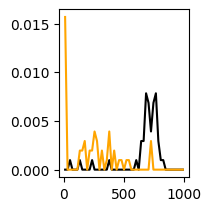

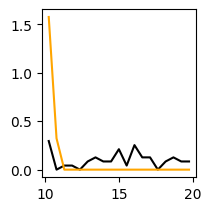

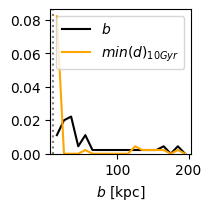

In [18]:
# MW - M31 b
fig, ax = plt.subplots(1, 1, figsize=(2, 2), layout="constrained")

bin_edges = np.linspace(0,1000,50)
hist, bin_edges = np.histogram(b_M31_MW_array, bins = bin_edges, density=True)
centers = (bin_edges[:-1] + bin_edges[1:]) / 2
ax.plot(centers, hist, color = 'black', label = r'$b$')

bin_edges = np.linspace(0,1000,50)
hist, bin_edges = np.histogram(dmin_M31_MW_array, bins = bin_edges, density=True)
centers = (bin_edges[:-1] + bin_edges[1:]) / 2
ax.plot(centers, hist, color = 'orange', label = r'$min(d)_{10 Gyr}$')

plt.savefig('plots/histogram_b_MW_M31'+suffix+'.pdf', dpi=300)


# MW - LMC b
fig, ax = plt.subplots(1, 1, figsize=(2, 2), layout="constrained")

bin_edges = np.linspace(10,20,20)
hist, bin_edges = np.histogram(b_LMC_MW_array, bins = bin_edges, density=True)
centers = (bin_edges[:-1] + bin_edges[1:]) / 2
ax.plot(centers, hist, color = 'black')

bin_edges = np.linspace(10,20,20)
hist, bin_edges = np.histogram(dmin_LMC_MW_array, bins = bin_edges, density=True)
centers = (bin_edges[:-1] + bin_edges[1:]) / 2
ax.plot(centers, hist, color = 'orange')

plt.savefig('plots/histogram_b_MW_M31'+suffix+'.pdf', dpi=300)


# M33 - M31 b
fig, ax = plt.subplots(1, 1, figsize=(2, 2), layout="constrained")

bin_edges = np.linspace(10,200,20)
hist, bin_edges = np.histogram(b_M33_M31_array, bins = bin_edges, density=True)
centers = (bin_edges[:-1] + bin_edges[1:]) / 2
ax.plot(centers, hist, color = 'black', label = r'$b$')

bin_edges = np.linspace(10,200,20)
hist, bin_edges = np.histogram(dmin_M33_M31_array, bins = bin_edges, density=True)
centers = (bin_edges[:-1] + bin_edges[1:]) / 2
ax.plot(centers, hist, color = 'orange', label = r'$min(d)_{10 Gyr}$')
ax.legend()

ax.set_xlabel(r'$b$ [kpc]')
ax.set_ylim(bottom=0)
ax.axvline([10], ls='dotted', color='grey')

plt.savefig('plots/histogram_b_M31_M33'+suffix+'.pdf', dpi=300)


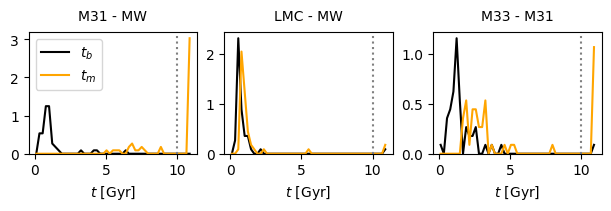

In [19]:
fig, axs = plt.subplots(1, 3, figsize=(6, 2), layout="constrained")

# MW - M31 b
bin_edges = np.linspace(0,11,50)
hist, bin_edges = np.histogram(t_b_M31_MW_array, bins = bin_edges, density=True)
centers = (bin_edges[:-1] + bin_edges[1:]) / 2
axs[0].plot(centers, hist, color = 'black', label = r'$t_b$')

bin_edges = np.linspace(0,11,50)
hist, bin_edges = np.histogram(t_m_M31_MW_array, bins = bin_edges, density=True)
centers = (bin_edges[:-1] + bin_edges[1:]) / 2
axs[0].plot(centers, hist, color = 'orange', label = r'$t_m$')

# MW - LMC b
bin_edges = np.linspace(0,11,50)
hist, bin_edges = np.histogram(t_b_LMC_MW_array, bins = bin_edges, density=True)
centers = (bin_edges[:-1] + bin_edges[1:]) / 2
axs[1].plot(centers, hist, color = 'black')

bin_edges = np.linspace(0,11,50)
hist, bin_edges = np.histogram(t_m_LMC_MW_array, bins = bin_edges, density=True)
centers = (bin_edges[:-1] + bin_edges[1:]) / 2
axs[1].plot(centers, hist, color = 'orange')

# M33 - M31 b
bin_edges = np.linspace(0,11,50)
hist, bin_edges = np.histogram(t_b_M33_M31_array, bins = bin_edges, density=True)
centers = (bin_edges[:-1] + bin_edges[1:]) / 2
axs[2].plot(centers, hist, color = 'black')

bin_edges = np.linspace(0,11,50)
hist, bin_edges = np.histogram(t_m_M33_M31_array, bins = bin_edges, density=True)
centers = (bin_edges[:-1] + bin_edges[1:]) / 2
axs[2].plot(centers, hist, color = 'orange')

axs[0].legend()

axs[0].text(0.5, 1.1, 'M31 - MW', transform=axs[0].transAxes, ha='center')
axs[1].text(0.5, 1.1, 'LMC - MW', transform=axs[1].transAxes, ha='center')
axs[2].text(0.5, 1.1, 'M33 - M31', transform=axs[2].transAxes, ha='center')

for i in range (3):
    axs[i].set_xlabel(r'$t$ [Gyr]')
    axs[i].axvline([10], ls='dotted', color='grey')
    axs[i].set_ylim(bottom=0)


plt.savefig('plots/histograms_t'+suffix+'.pdf', dpi=300)

### Scatter plots

N_s: 50
(50, 4, 3, 10001)
norm: 127.74498812610535
[[   0.            0.            0.        ]
 [  41.73986542 -120.24306945  -10.87059684]
 [ -37.00195968 -219.52299474  224.31453101]
 [  17.40490899   48.74224499  127.38203341]]
vt_IC [62.275531838910815, 55.803519031634444, 53.58867287742181, 62.005257136596384, 29.336155812162207, 20.174835314852665, 85.91242017725233, 93.35990158442559, 106.38961869173627, 65.70362958799558, 123.42434480774689, 80.01567809550731, 43.189846129068016, 98.74658230464887, 35.20137454959153, 92.3895472486157, 139.7755465560512, 68.34616309585994, 98.36112597806782, 62.525407763532336, 94.47474609174249, 54.8375910945387, 66.55957638078172, 92.73614927790223, 62.50859109646981, 73.82811806082204, 64.37043645586219, 71.31536810666087, 60.89591006551928, 38.548540285338476, 27.08049717790978, 44.539011634007046, 75.13044653607231, 48.337095723478285, 84.00529639740137, 97.5250938193988, 91.00339505618643, 82.40036985577855, 56.6992708988357, 108.75651881

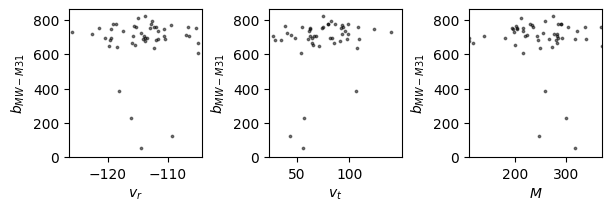

In [20]:
fig, axs = plt.subplots(1, 3, figsize=(6, 2), layout="constrained")

print ("N_s:", N_s)

print(vels.shape)
print ("norm:", np.linalg.norm(vels[3,1,:,0]) )
print (vels[3,:,:,0])


# Mass vs b
masses_IC = []
vr_IC = []
vt_IC = []
for s in range(N_s):
    masses_IC.append(ICs['masses'][s][1]+ICs['masses'][s][0])
    v = np.linalg.norm(vels[s,1,:,0])
    vr = np.dot(orbits[s,1,:,0],vels[s,1,:,0]) / np.linalg.norm(orbits[s,1,:,0])
    vt = np.sqrt(v**2 - vr**2)
    vr_IC.append(vr)
    vt_IC.append(vt)

axs[0].scatter(vr_IC, b_M31_MW_array, color = 'black', s=3, alpha=.5)
axs[1].scatter(vt_IC, b_M31_MW_array, color = 'black', s=3, alpha=.5)
axs[2].scatter(masses_IC, b_M31_MW_array, color = 'black', s=3, alpha=.5)

#axs[0].plot(ICs['masses'][:][0], b_M31_MW_array, hist, color = 'black', label = r'$t_b$')


for i in range (3):
    axs[i].set_ylabel(r'$b_{MW-M31}$')
    
    axs[i].axvline([10], ls='dotted', color='grey')
    axs[i].set_ylim(bottom=0)

axs[0].set_xlim(np.percentile(vr_IC,1),np.percentile(vr_IC,99))
axs[0].set_xlabel(r'$v_r$')

axs[1].set_xlim(np.percentile(vt_IC,1),np.percentile(vt_IC,99))
axs[1].set_xlabel(r'$v_t$')

axs[2].set_xlim(np.percentile(masses_IC,1),np.percentile(masses_IC,99))
axs[2].set_xlabel(r'$M$')

print ("vt_IC", vt_IC)


plt.savefig('plots/scatter-mass'+suffix+'.pdf', dpi=300)

### Plot the distances

In [21]:
for s in range (N_s):
#        axs[0].scatter(t_all[idx_merger_MW_M31[s]], d_M31_MW[s,idx_merger_MW_M31[s]], s=6, edgecolor='none', facecolor='white', marker = 'o', alpha=.7)
    print (d_M31_MW[s,idx_merger_MW_M31[s]])
print (d_M31_MW)

445.5730996853261
-1.0
565.7787800942365
-1.0
-1.0
-1.0
574.7176275795805
440.2643447293746
455.8032024207024
-1.0
977.6687567013702
467.6108114111218
206.14560334565445
-1.0
419.13064296738014
309.88469972484904
1036.8294457069203
425.4717582749481
572.3154788010704
568.0394973493911
-1.0
514.5698743510221
506.9484858124513
399.40579650278556
572.4429738167605
496.10318550289304
422.1146453466952
-1.0
668.4460809925818
-1.0
-1.0
468.24085721035743
-1.0
-1.0
384.3204998221744
602.6685038193341
860.9802267907369
466.0500477275832
-1.0
629.3172894555319
900.9703771224057
534.8288068410684
716.0624075633207
462.3614026231265
449.3395541306129
-1.0
-1.0
512.5584214953487
-1.0
614.5225774558572
[[772.73595978 772.6307532  772.52575174 ... 445.33904288 445.45608378
  445.57309969]
 [801.34118085 801.22671872 801.1122326  ...  -1.          -1.
  529.45347448]
 [659.03833884 658.9333926  658.82861135 ... 565.65629926 565.71754862
  565.77878009]
 ...
 [761.02496575 760.90752696 760.79034628 ..

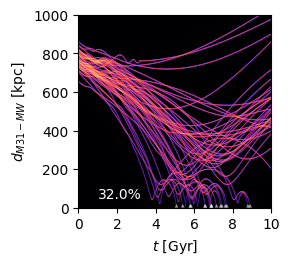

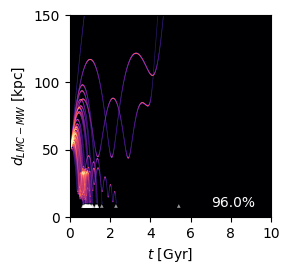

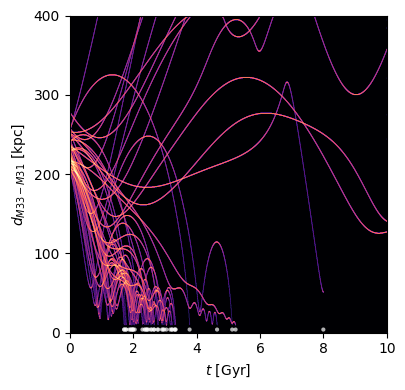

In [22]:
if 'M31' in galaxies and 'MW' in galaxies:

    fig, ax = plt.subplots(1, 1, figsize=(3, 3), layout="tight")

    x = np.ravel(np.tile(t_all,N_s)) # repeats t_all

    y = np.ravel(d_M31_MW) # repeats all the distances

    xedges = np.linspace(0,10,1000)
    yedges = np.linspace(0,1000,1000)
    bins = (xedges, yedges)
    
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=bins)
    heatmap = gaussian_filter(heatmap, sigma=0.2)
    heatmap = np.maximum(heatmap, 0.2)
    
    ax.imshow(heatmap.T, origin='lower', norm=LogNorm(vmin = 0.2, vmax = np.percentile(heatmap,99.9)), cmap = 'magma')

    ax.set_xlim(0,1000)
    ax.set_ylim(0,1000)

    ax.set_xticks([0,1*1000/5,2*1000/5,3*1000/5,4*1000/5,1000])
    ax.set_xticklabels(['0','2', '4', '6', '8', '10'])

    ax.set_xlabel(r'$t$ [Gyr]')
    ax.set_ylabel(r'$d_{M31-MW}$ [kpc]')
    
    ax.set_yticks([0,1000/5,2*1000/5,3*1000/5,4*1000/5,1000])
    ax.set_yticklabels(['0','200', '400', '600', '800', '1000'])
    
    mergercounter = 0.
    
    for s in range (N_s):
        if idx_merger_MW_M31[s] > 0:
            ax.scatter( t_all[idx_merger_MW_M31[s]]*100, 10, s=7, edgecolor='none', facecolor='white', marker = '^', alpha=.6)
            mergercounter += 1

    ax.text(0.1, 0.05, str(np.rint(mergercounter / N_s * 100))+'%', transform=ax.transAxes, color ='white')
    
    plt.savefig('plots/distance_MW_to_M31_'+suffix+'.pdf', dpi=300)

if 'LMC' in galaxies and 'MW' in galaxies:

    fig, ax = plt.subplots(1, 1, figsize=(3, 3), layout="tight")

    x = np.ravel(np.tile(t_all,N_s)) # repeats t_all

    y = np.ravel(d_LMC_MW) # repeats all the distances

    xedges = np.linspace(0,10,1000)
    yedges = np.linspace(0,150,1000)
    bins = (xedges, yedges)
    
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=bins)
    heatmap = gaussian_filter(heatmap, sigma=0.2)
    heatmap = np.maximum(heatmap, 0.2)
    
    ax.imshow(heatmap.T, origin='lower', norm=LogNorm(vmin = 0.2, vmax = np.percentile(heatmap,99.9)), cmap = 'magma')

    ax.set_xlim(0,1000)
    ax.set_ylim(0,1000)

    ax.set_xticks([0,1*1000/5,2*1000/5,3*1000/5,4*1000/5,1000])
    ax.set_xticklabels(['0','2', '4', '6', '8', '10'])

    ax.set_yticks([0,1*1000/3,2*1000/3,1000])
    ax.set_yticklabels(['0','50', '100', '150'])

    ax.set_ylabel(r'$d_{LMC-MW}$ [kpc]')
    ax.set_xlabel(r'$t$ [Gyr]')

    mergercounter = 0.
    
    for s in range (N_s):
        if idx_merger_LMC_MW[s] > 0:
            ax.scatter( t_all[idx_merger_LMC_MW[s]]*100, 8*1000/150, s=7, edgecolor='none', facecolor='white', marker = '^', alpha=.6)
            mergercounter += 1

    ax.text(0.7, 0.05, str(np.floor(mergercounter / N_s * 100))+'%', transform=ax.transAxes, color ='white')


    plt.savefig('plots/distance_MW_to_LMC_'+suffix+'.pdf', dpi=300)

if 'M33' in galaxies and 'M31' in galaxies:

    fig, ax = plt.subplots(1, 1, figsize=(11, 4), layout="tight")

    x = np.ravel(np.tile(t_all,N_s)) # repeats t_all

    y = np.ravel(d_M33_M31) # repeats all the distances

    xedges = np.linspace(0,10,1000)
    yedges = np.linspace(0,400,1000)
    bins = (xedges, yedges)
    
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=bins)
    heatmap = gaussian_filter(heatmap, sigma=0.2)
    heatmap = np.maximum(heatmap, 0.2)
    
    ax.imshow(heatmap.T, origin='lower', norm=LogNorm(vmin = 0.2, vmax = np.percentile(heatmap,99.9)), cmap = 'magma')

    ax.set_xlim(0,1000)
    ax.set_ylim(0,1000)

    ax.set_xticks([0,1*1000/5,2*1000/5,3*1000/5,4*1000/5,1000])
    ax.set_xticklabels(['0','2', '4', '6', '8', '10'])

    ax.set_yticks([0,1*1000/4,2*1000/4,3*1000/4,1000])
    ax.set_yticklabels(['0','100', '200', '300', '400'])

    ax.set_ylabel(r'$d_{M33-M31}$ [kpc]')
    ax.set_xlabel(r'$t$ [Gyr]')
    
    for s in range (N_s):
        if idx_merger_M33_M31[s] > 0:
            ax.scatter( t_all[idx_merger_M33_M31[s]]*100, 10, s=9, edgecolor='none', facecolor='white', marker = 'o', alpha=.7)
            
    

    plt.savefig('plots/distance_M33_to_M31_'+suffix+'.pdf', dpi=300)




## plot heatmaps, with each orbit rotated into the initial MW-M31 orbital plane.

### edge on

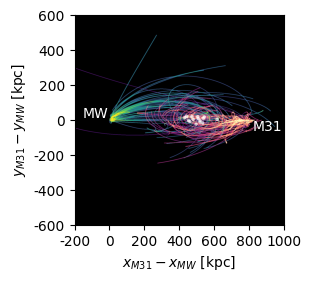

In [23]:
cmapMW = cm.viridis
cmapMW.set_under('black')

cmapM31 = cm.magma
cmapM31.set_under('black')

# Rotated positions

fig, ax = plt.subplots(1, 1, figsize=(3, 3), layout="constrained")

x_M31 = []
y_M31 = []
z_M31 = []

x_MW = []
y_MW = []
z_MW = []

for s in range (N_s):

    # calculate the rotation matrix
    v_M31_mean = [vels[s,1,0,0], vels[s,1,1,0], vels[s,1,2,0] ]
    pos_M31_mean = [orbits[s,1,0,0], orbits[s,1,1,0], orbits[s,1,2,0] ]

    first = pos_M31_mean / np.linalg.norm(pos_M31_mean)
    
    second = np.cross(pos_M31_mean, v_M31_mean)
    second = second / np.linalg.norm(second)

    third = np.cross(first, second) 
    third = third / np.linalg.norm(third)

    M = np.array([first, second, third])

    # if there is a merger, only plot up to the merger
    if idx_merger_MW_M31[s] > 0:

        x_MW_s = orbits[s,1,0,idx_merger_MW_M31[s]] 
        y_MW_s = orbits[s,1,1,idx_merger_MW_M31[s]]  
        z_MW_s = orbits[s,1,2,idx_merger_MW_M31[s]] 

        rotated = np.dot(np.array([x_MW_s,y_MW_s,z_MW_s]).T, M.T).T

        x_MW_s = rotated[0]
        y_MW_s = rotated[1]
        z_MW_s = rotated[2]

        ax.scatter((x_MW_s+200), (y_MW_s+600), s=6, edgecolor='none', facecolor='white', marker = 'o', alpha=.7)

        # MW    
        rotated = np.dot(np.array([orbits[s,0,0,0:idx_merger_MW_M31[s]],orbits[s,0,1,0:idx_merger_MW_M31[s]],orbits[s,0,2,0:idx_merger_MW_M31[s]]]).T, M.T).T
    
        x_MW.extend(rotated[0])
        y_MW.extend(rotated[1])
        z_MW.extend(rotated[2])
        
        # M31
        
        rotated = np.dot(np.array([orbits[s,1,0,0:idx_merger_MW_M31[s]],orbits[s,1,1,0:idx_merger_MW_M31[s]],orbits[s,1,2,0:idx_merger_MW_M31[s]]]).T, M.T).T
    
        x_M31.extend(rotated[0])
        y_M31.extend(rotated[1])
        z_M31.extend(rotated[2])


    else:
        
        # MW    
        rotated = np.dot(np.array([orbits[s,0,0,:],orbits[s,0,1,:],orbits[s,0,2,:]]).T, M.T).T
    
        x_MW.extend(rotated[0])
        y_MW.extend(rotated[1])
        z_MW.extend(rotated[2])
        
        # M31
        
        rotated = np.dot(np.array([orbits[s,1,0,:],orbits[s,1,1,:],orbits[s,1,2,:]]).T, M.T).T
    
        x_M31.extend(rotated[0])
        y_M31.extend(rotated[1])
        z_M31.extend(rotated[2])

x_MW = np.ravel(x_MW)
y_MW = np.ravel(y_MW)
z_MW = np.ravel(z_MW)

x_M31 = np.ravel(x_M31)
y_M31 = np.ravel(y_M31)
z_M31 = np.ravel(z_M31)

# x vs y

xedges = np.linspace(-200,1000,1200)
yedges = np.linspace(-600,600,1200)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
bins = (xedges, yedges)

heatmap, xedges, yedges = np.histogram2d(x_MW, y_MW, bins=bins)
heatmap = gaussian_filter(heatmap, sigma=1)

heatmap = np.log(heatmap**.2+0.0001)
heatmap = heatmap / np.percentile(heatmap,99.95)
image1 = Image.fromarray(np.uint8(cmapMW(heatmap.T)*255))

heatmap, xedges, yedges = np.histogram2d(x_M31, y_M31, bins=bins)
heatmap = gaussian_filter(heatmap, sigma=1)

heatmap = np.log(heatmap**.2+0.0001)
heatmap = heatmap / np.percentile(heatmap,99.9)
image2 = Image.fromarray(np.uint8(cmapM31(heatmap.T)*255))

combined = ImageChops.lighter(image1,image2)

ax.imshow(combined, origin='lower')



ax.set_xlim(0,1200)
ax.set_ylim(0,1200)

ax.set_xticks     ([0,200,400,600,800,1000,1200])
ax.set_xticklabels([-200,0,200,400,600,800,1000])
ax.set_yticks([0,200,400,600,800,1000,1200])
ax.set_yticklabels([-600,-400,-200,0,200,400,600])

ax.set_xlabel(r'$x_{M31} - x_{MW}$ [kpc]')
ax.set_ylabel(r'$y_{M31} - y_{MW}$ [kpc]')

ax.text(0.1, 0.53, 'MW', transform=ax.transAxes, ha='center', va='center', color="white")
ax.text(0.92, 0.47, 'M31', transform=ax.transAxes, ha='center', va='center', color="white")

plt.savefig('plots/heatmap_edge_M31'+suffix+'.pdf', dpi=200)
plt.savefig('plots/heatmap_edge_M31_highdpi'+suffix+'.pdf', dpi=300)



### face on

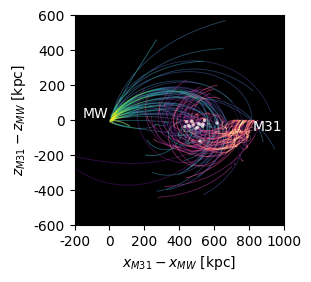

In [24]:
cmapMW = cm.viridis
cmapMW.set_under('black')

cmapM31 = cm.magma
cmapM31.set_under('black')

# Rotated positions

fig, ax = plt.subplots(1, 1, figsize=(3, 3), layout="constrained")

x_M31 = []
y_M31 = []
z_M31 = []

x_MW = []
y_MW = []
z_MW = []

for s in range (N_s):

    # calculate the rotation matrix
    v_M31_mean = [vels[s,1,0,0], vels[s,1,1,0], vels[s,1,2,0] ]
    pos_M31_mean = [orbits[s,1,0,0], orbits[s,1,1,0], orbits[s,1,2,0] ]

    first = pos_M31_mean / np.linalg.norm(pos_M31_mean)
    
    second = np.cross(pos_M31_mean, v_M31_mean)
    second = second / np.linalg.norm(second)

    third = np.cross(first, second) 
    third = third / np.linalg.norm(third)

    M = np.array([first, second, third])

    # if there is a merger, only plot up to the merger
    if idx_merger_MW_M31[s] > 0:

        x_MW_s = orbits[s,1,0,idx_merger_MW_M31[s]] 
        y_MW_s = orbits[s,1,1,idx_merger_MW_M31[s]]  
        z_MW_s = orbits[s,1,2,idx_merger_MW_M31[s]] 

        rotated = np.dot(np.array([x_MW_s,y_MW_s,z_MW_s]).T, M.T).T

        x_MW_s = rotated[0]
        y_MW_s = rotated[1]
        z_MW_s = rotated[2]

        ax.scatter((x_MW_s+200), (z_MW_s+600), s=6, edgecolor='none', facecolor='white', marker = 'o', alpha=.7)

        # MW    
        rotated = np.dot(np.array([orbits[s,0,0,0:idx_merger_MW_M31[s]],orbits[s,0,1,0:idx_merger_MW_M31[s]],orbits[s,0,2,0:idx_merger_MW_M31[s]]]).T, M.T).T
    
        x_MW.extend(rotated[0])
        y_MW.extend(rotated[1])
        z_MW.extend(rotated[2])
        
        # M31
        
        rotated = np.dot(np.array([orbits[s,1,0,0:idx_merger_MW_M31[s]],orbits[s,1,1,0:idx_merger_MW_M31[s]],orbits[s,1,2,0:idx_merger_MW_M31[s]]]).T, M.T).T
    
        x_M31.extend(rotated[0])
        y_M31.extend(rotated[1])
        z_M31.extend(rotated[2])


    else:
        
        # MW    
        rotated = np.dot(np.array([orbits[s,0,0,:],orbits[s,0,1,:],orbits[s,0,2,:]]).T, M.T).T
    
        x_MW.extend(rotated[0])
        y_MW.extend(rotated[1])
        z_MW.extend(rotated[2])
        
        # M31
        
        rotated = np.dot(np.array([orbits[s,1,0,:],orbits[s,1,1,:],orbits[s,1,2,:]]).T, M.T).T
    
        x_M31.extend(rotated[0])
        y_M31.extend(rotated[1])
        z_M31.extend(rotated[2])

x_MW = np.ravel(x_MW)
y_MW = np.ravel(y_MW)
z_MW = np.ravel(z_MW)

x_M31 = np.ravel(x_M31)
y_M31 = np.ravel(y_M31)
z_M31 = np.ravel(z_M31)


# x vs z

xedges = np.linspace(-200,1000,1200)
yedges = np.linspace(-600,600,1200)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
bins = (xedges, yedges)

heatmap, xedges, yedges = np.histogram2d(x_MW, z_MW, bins=bins)
heatmap = gaussian_filter(heatmap, sigma=1)

heatmap = (np.log(heatmap**.2+0.0001))
heatmap = heatmap / np.percentile(heatmap,99.95)
image1 = Image.fromarray(np.uint8(cmapMW(heatmap.T)*255))

heatmap, xedges, yedges = np.histogram2d(x_M31, z_M31, bins=bins)
heatmap = gaussian_filter(heatmap, sigma=1)

heatmap = np.log(heatmap**.3+0.0001)
heatmap = heatmap / np.percentile(heatmap,99.95)
image2 = Image.fromarray(np.uint8(cmapM31(heatmap.T)*255))

combined = ImageChops.lighter(image1,image2)

ax.imshow(combined, origin='lower')


ax.set_xlim(0,1200)
ax.set_ylim(0,1200)

ax.set_xticks([0,200,400,600,800,1000,1200])
ax.set_xticklabels([-200,0,200,400,600,800,1000])
ax.set_yticks([0,200,400,600,800,1000,1200])
ax.set_yticklabels([-600,-400,-200,0,200,400,600])

ax.set_xlabel(r'$x_{M31} - x_{MW}$ [kpc]')
ax.set_ylabel(r'$z_{M31} - z_{MW}$ [kpc]')

ax.text(0.1, 0.53, 'MW', transform=ax.transAxes, ha='center', va='center', color="white")
ax.text(0.92, 0.47, 'M31', transform=ax.transAxes, ha='center', va='center', color="white")

plt.savefig('plots/heatmap_face_M31'+suffix+'.pdf', dpi=200)
plt.savefig('plots/heatmap_face_highdpi'+suffix+'.pdf', dpi=300)

#plt.show()



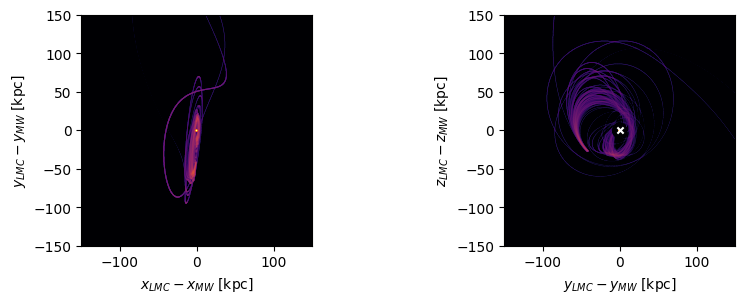

In [25]:
# Positions of LMC
if N > 2:
    fig, axs = plt.subplots(1, 2, figsize=(10, 3))
    
    x = np.ravel(orbits[:,2,0,:]) - np.ravel(orbits[:,0,0,:])
    y = np.ravel(orbits[:,2,1,:]) - np.ravel(orbits[:,0,1,:])
    z = np.ravel(orbits[:,2,2,:]) - np.ravel(orbits[:,0,2,:])
    
    #indices = np.where( (x < 100) & (x > -100) & (y > -100) & (y < 100) & (z > -100) & (z < 100))[0]
    
    xedges = np.linspace(-150,150,1000)
    yedges = np.linspace(-150,150,1000)
    extent = [-150, 150, -150, 150]
    bins = (xedges, yedges)
    
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=bins)
    heatmap = gaussian_filter(heatmap, sigma=1)
    heatmap = np.maximum(heatmap, 0.001)
    axs[0].imshow(heatmap.T, origin='lower', extent = extent, norm=LogNorm(vmin = .1, vmax = 1000), cmap = 'inferno')
    
    heatmap, xedges, yedges = np.histogram2d(y, z, bins=bins)
    heatmap = gaussian_filter(heatmap, sigma=1)
    heatmap = np.maximum(heatmap, 0.01)
    axs[1].imshow(heatmap.T, extent=extent, origin='lower',  norm=LogNorm(vmin = .1, vmax = 1000), cmap = 'inferno')
    
    # overplot the MW
    
    axs[1].scatter([0],[0], s=20, color='white', marker = 'x')
    
    axs[0].set_xlabel(r'$x_{LMC} - x_{MW}$ [kpc]')
    axs[0].set_ylabel(r'$y_{LMC} - y_{MW}$ [kpc]')
    
    axs[1].set_xlabel(r'$y_{LMC} - y_{MW}$ [kpc]')
    axs[1].set_ylabel(r'$z_{LMC} - z_{MW}$ [kpc]')
    
    
    plt.savefig('plots/heatmap_LMC'+suffix+'.pdf', dpi=300)
    
    #plt.show()

## Test M31 motion:

Reflex proper motion: (𝜇 𝛼 , 𝜇 𝛿 ) = (37.6 ± 0.6, −20.9 ±0.4) 𝜇as/yr. 
When subtracting 𝜇 from the corrected values, we thus
derive the final transverse velocity of M31 with respect to the centre
of the Milky Way. These values are provided in Table 5.

d = 785 kpc

we make use of the recent value of the motion of the Sun
with respect to the Galactic centre derived by Reid et al. (2019),
(𝑈 , 𝑉 + 𝑉𝑐 , 𝑊 ) = (10.6 ± 1.2, 247 ± 4, 7.6 ± 0.7) km s−1

Table 4. Transverse velocities corrected for apparent QSO motion and systematic method bias.

BPM

mu alpha 48.0 ± 10.2 uas
mu delta −38.4 ± 7.8 uas

v alpha: 178.7 km/s
v delta: −142.7
v trans: 231.1 

Table 5. Transverse velocities in non-rotating Galactic frame, centered on the Sun.

Mu alpha: 10.4 ± 10.3 uas
Mu delta: −17.5 ± 7.8
v alpha: 38.8
v delta: −65.0
v trans: 84.5 km/s


In [26]:
coo=(SkyCoord.from_name('M31'))
sky=SkyCoord(ra=coo.ra,dec=coo.dec,frame='icrs',distance=785*u.kpc,
             pm_ra_cosdec=48.0*u.uas/u.yr, pm_dec= -38.4*u.uas/u.yr,radial_velocity=-301*u.km/u.s)

gal = sky.transform_to(Galactocentric(galcen_v_sun=(10.6, 247, 7.6)*u.km/u.s)) #convert ICRS coordinates to Galactocentric coordinates

pos = [gal.x.value,gal.y.value,gal.z.value] #positions array for the concerned galaxy
vel = [gal.v_x.value, gal.v_y.value, gal.v_z.value] #velocities array

print ("sky:", sky)
print ("gal:", gal)



v = np.linalg.norm(vel)
print ("total vel:", v)
vr = np.dot(pos,vel) / np.linalg.norm(pos)
print ("vr:", np.dot(pos,vel) / np.linalg.norm(pos))
vt = np.sqrt(v**2 - vr**2)
print ("vt:", vt)


sky: <SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, kpc)
    (10.6847083, 41.26875, 785.)
 (pm_ra_cosdec, pm_dec, radial_velocity) in (mas / yr, mas / yr, km / s)
    (0.048, -0.0384, -301.)>
gal: <SkyCoord (Galactocentric: galcen_coord=<ICRS Coordinate: (ra, dec) in deg
    (266.4051, -28.936175)>, galcen_distance=8.122 kpc, galcen_v_sun=(10.6, 247., 7.6) km / s, z_sun=20.8 pc, roll=0.0 deg): (x, y, z) in kpc
    (-386.74353986, 624.59382527, -287.64786847)
 (v_x, v_y, v_z) in km / s
    (35.55174333, -129.17404094, -20.62083958)>
total vel: 135.5547060494753
vr: -112.17451602573892
vt: 76.10490317023532


In [27]:
pm_ra_cosdec_values = np.linspace(48-10.2,48+10.2,21)
pm_dec_values = np.linspace(-38.4-7.8,-38.4+7.8,21)

for i in range(20):
    for j in range(20):
        
        coo=(SkyCoord.from_name('M31'))
        sky=SkyCoord(ra=coo.ra,dec=coo.dec,frame='icrs',distance=770*u.kpc,
                     pm_ra_cosdec=pm_ra_cosdec_values[i]*u.uas/u.yr, pm_dec= pm_dec_values[j]*u.uas/u.yr,radial_velocity=-301*u.km/u.s)
        
        gal = sky.transform_to(Galactocentric(galcen_v_sun=(10.6, 247, 7.6)*u.km/u.s)) #convert ICRS coordinates to Galactocentric coordinates
        
        pos = [gal.x.value,gal.y.value,gal.z.value] #positions array for the concerned galaxy
        vel = [gal.v_x.value, gal.v_y.value, gal.v_z.value] #velocities array
        
#        print ("sky:", sky)
#        print ("gal:", gal)
        v = np.linalg.norm(vel)
#        print ("total vel:", v)
        vr = np.dot(pos,vel) / np.linalg.norm(pos)
#        print ("vr:", np.dot(pos,vel) / np.linalg.norm(pos))
        vt = np.sqrt(v**2 - vr**2)
        if vt < 40 and vr < -105 and vr > -120:
            print ("pmra:", pm_ra_cosdec_values[i], "pmdec:", pm_dec_values[j], "vt:", vt, "vr:", vr)

print ("all done")

coo=(SkyCoord.from_name('M31'))
sky=SkyCoord(ra=coo.ra,dec=coo.dec,frame='icrs',distance=770*u.kpc,
             pm_ra_cosdec=38.9*u.uas/u.yr, pm_dec= -32.2*u.uas/u.yr,radial_velocity=-301*u.km/u.s)

gal = sky.transform_to(Galactocentric(galcen_v_sun=(10.6, 247, 7.6)*u.km/u.s)) #convert ICRS coordinates to Galactocentric coordinates

pos = [gal.x.value,gal.y.value,gal.z.value] #positions array for the concerned galaxy
vel = [gal.v_x.value, gal.v_y.value, gal.v_z.value] #velocities array

#        print ("sky:", sky)
#        print ("gal:", gal)
v = np.linalg.norm(vel)
#        print ("total vel:", v)
vr = np.dot(pos,vel) / np.linalg.norm(pos)
#        print ("vr:", np.dot(pos,vel) / np.linalg.norm(pos))
vt = np.sqrt(v**2 - vr**2)
if vt < 40 and vr < -105 and vr > -120:
    print ("pmra:", pm_ra_cosdec_values[i], "pmdec:", pm_dec_values[j], "vt:", vt, "vr:", vr)


pmra: 37.8 pmdec: -32.16 vt: 39.3803716385954 vr: -112.47317136728773
pmra: 37.8 pmdec: -31.379999999999995 vt: 36.53396817980926 vr: -112.46655977486742
pmra: 38.82 pmdec: -32.16 vt: 39.47593542235856 vr: -112.44003355046044
pmra: 38.82 pmdec: -31.379999999999995 vt: 36.63695129035952 vr: -112.43342195804013
pmra: 39.839999999999996 pmdec: -32.16 vt: 39.92000765315815 vr: -112.40689573363315
pmra: 39.839999999999996 pmdec: -31.379999999999995 vt: 37.1150009460147 vr: -112.40028414121282
pmra: 40.86 pmdec: -31.379999999999995 vt: 37.95394731875478 vr: -112.3671463243855
pmra: 41.879999999999995 pmdec: -31.379999999999995 vt: 39.130584782348734 vr: -112.33400850755825
all done
pmra: 57.18000000000001 pmdec: -31.379999999999995 vt: 39.64380307814075 vr: -112.4377735620249


# Old IC generation

In [28]:
ICs = {'masses': [], 'positions': [], 'velocities': [], 'concentrations': []}

print ("N_s", N_s)
print ("N", N)


for s in range (N_s):

    np.random.seed(s * 1) # for the MW
    
    masses = []
    positions = []
    concentrations = []
    velocities = []


    if 'MW' in galaxies:

        np.random.seed(s) 
        
        pos_MW = [0.,0.,0.]
        vel_MW = [0.,0.,0.]
        mass_MW = np.random.normal(loc=m_MW_mean, scale=m_MW_sigma, size=1)

        masses.append(mass_MW)  
        positions.append(pos_MW)
        velocities.append(vel_MW)
        concentrations.append(c_MW)


    if 'M31' in galaxies:

        np.random.seed(s + int(1e8)) 
    
        pos_M31, vel_M31, mass_M31 = get_galaxy_coordinates('M31',
                                                        np.random.normal(loc=dmod_M31_mean, scale=dmod_M31_sigma, size=1),
                                                        np.random.normal(loc=pm_ra_cosdec_M31_mean, scale=pm_ra_cosdec_M31_sigma, size=1),
                                                        np.random.normal(loc=pm_dec_M31_mean, scale=pm_dec_M31_sigma, size=1),
                                                        np.random.normal(loc=vr_M31_mean, scale=vr_M31_sigma, size=1),
                                                        np.random.normal(loc=m_M31_mean, scale=m_M31_sigma, size=1) )
        
        masses.append(mass_M31)
        positions.append(pos_M31)
        velocities.append(vel_M31)
        concentrations.append(c_M31)

    
    if 'LMC' in galaxies:

        np.random.seed(s + int(2e8)) 
    
        pos_LMC, vel_LMC, mass_LMC = get_galaxy_coordinates('LMC',
                                                            np.random.normal(loc=dmod_LMC_mean, scale=dmod_LMC_sigma, size=1),
                                                            np.random.normal(loc=pm_ra_cosdec_LMC_mean, scale=pm_ra_cosdec_LMC_sigma, size=1),
                                                            np.random.normal(loc=pm_dec_LMC_mean, scale=pm_dec_LMC_sigma, size=1),
                                                            np.random.normal(loc=vr_LMC_mean, scale=vr_LMC_sigma, size=1),
                                                            np.random.normal(loc=m_LMC_mean, scale=m_LMC_sigma, size=1) )

        masses.append(mass_LMC)
        positions.append(pos_LMC)
        velocities.append(vel_LMC)
        concentrations.append(c_LMC)
    
    if 'M33' in galaxies:
        
        np.random.seed(s + int(3e8))

        pos_M33, vel_M33, mass_M33 = get_galaxy_coordinates('M33',
                                                        np.random.normal(loc=dmod_M33_mean, scale=dmod_M33_sigma, size=1),
                                                        np.random.normal(loc=pm_ra_cosdec_M33_mean, scale=pm_ra_cosdec_M33_sigma, size=1),
                                                        np.random.normal(loc=pm_dec_M33_mean, scale=pm_dec_M33_sigma, size=1),
                                                        np.random.normal(loc=vr_M33_mean, scale=vr_M33_sigma, size=1),
                                                        np.random.normal(loc=m_M33_mean, scale=m_M33_sigma, size=1) )

        masses.append(mass_M33)
        positions.append(pos_M33)
        velocities.append(vel_M33)
        concentrations.append(c_M33)

    ICs['masses'].append(masses)
    ICs['positions'].append(positions)
    ICs['concentrations'].append(concentrations)
    ICs['velocities'].append(velocities)


print ("galaxies:", galaxies)
print (  ICs['masses'] )
print ("positions", ICs['positions'])

#print ("velocities", ICs['velocities'])



N_s 50
N 4
galaxies: ['M31' 'MW' 'LMC' 'M33']
[[array([135.28104692]), array([162.16449221]), array([23.74246429]), array([18.73561036])], [array([132.48690727]), array([107.09310235]), array([3.45711546]), array([69.26377713])], [array([91.66484305]), array([311.20273313]), array([-9.05827027]), array([22.93231213])], [array([135.77256947]), array([88.32245793]), array([10.92467219]), array([17.33597254])], [array([101.01123414]), array([27.71771199]), array([23.40938998]), array([40.61646463])], [array([108.82454974]), array([118.99715001]), array([36.78879356]), array([30.92450355])], [array([93.76432653]), array([154.3687285]), array([25.52384127]), array([61.68837095])], [array([133.81051408]), array([96.451187]), array([6.84147683]), array([38.87582188])], [array([101.82409433]), array([68.74491202]), array([29.56757243]), array([47.78647521])], [array([100.02217109]), array([212.55637642]), array([27.87544561]), array([46.8838398])], [array([126.63173008]), array([130.43363994])